本章涵盖以下内容：

+ **介绍不同的LLM微调方法**
+ **准备用于文本分类任务的数据集**
+ **调整预训练的 LLM 以便微调**
+ **微调 LLM 以识别垃圾短信**
+ **评估微调后的 LLM 分类器的准确性**
+ **使用微调后的 LLM 对新数据进行分类**


-----

- [6.1 不同类型的微调](#61-不同类型的微调)
- [6.2 准备数据集](#62-准备数据集)
- [6.3 创建数据加载器](#63-创建数据加载器)
- [6.4 使用预训练权重初始化模型](#64-使用预训练权重初始化模型)
- [6.5 添加分类头](#65-添加分类头)
- [6.6 计算分类损失和准确率](#66-计算分类损失和准确率)
- [6.7 使用监督数据对模型进行微调](#67-使用监督数据对模型进行微调)
- [6.8 将 LLM 用于垃圾短信分类](#68-将-llm-用于垃圾短信分类)
- [6.9 本章摘要](#69-本章摘要)


-----

在之前的章节中，我们实现了 LLM 的架构，进行了预训练，并学习了如何从外部来源（如 OpenAI）导入预训练权重。本章将在此基础上，通过微调 LLM 来完成特定目标任务，比如文本分类（见图 6.1）。我们将以一个具体的例子来说明如何将文本消息分类为垃圾短信或正常短信。

<img src="../images/chapter6/figure6.1.png" width="75%" />

图 6.1 展示了微调 LLM 的两种主要方式：用于分类的微调（步骤 8）和用于指令遵循的微调（步骤 9）。在下一节中，我们将深入探讨这两种微调方式。

## 6.1 不同类型的微调

微调语言模型最常见的方法是指令微调和分类微调。指令微调通过在一组任务上使用特定指令训练模型，用以提升模型对自然语言提示中任务描述的理解和执行能力，如图 6.2 所示。

<img src="../images/chapter6/figure6.2.png" width="75%" />

下一章将讨论指令微调，相关内容在图 6.2 中有所展示。而本章的重点是分类微调，如果您有机器学习基础，可能已经对这一概念比较熟悉。

在分类微调中，模型被训练用来识别特定的一组类别标签，比如“垃圾短信”和“非垃圾短信”。分类任务的应用不仅限于 LLM 和电子邮件过滤，还包括从图像中识别不同种类的植物、将新闻分类到体育、政治或科技等主题，以及在医学影像中区分良性和恶性肿瘤。

但有一个关键点需要注意，经过分类微调的模型只能预测训练中遇到的类别。例如，它可以判断某内容是‘垃圾短信’还是‘非垃圾短信’（如图 6.3 所示），但不能对输入文本提供其他方面的信息。

<img src="../images/chapter6/figure6.3.png" width="75%" />

与图6.3中所示的分类微调模型不同，指令微调模型通常可以执行更广泛的任务。分类微调模型可以视为高度专业化的模型，而相比之下，开发一个适用于各种任务的通用型模型通常更具挑战性。

> [!NOTE]
>
> **选择合适的微调方式**
>
> 指令微调提升了模型基于用户指令进行理解和生成响应的能力。它适用于需要基于复杂用户指令处理多任务的模型，增强模型的灵活性和交互质量。而分类微调则适合需要将数据精确分类为预定义类别的任务，例如情感分析或垃圾短信检测。
>
> 虽然指令微调用途更广泛，但需要更大的数据集和更多的计算资源，才能训练出能胜任多种任务的模型。相比之下，分类微调所需的数据和计算量更少，但用途局限于模型已训练的特定类别。


## 6.2 准备数据集

在本章的剩余部分，我们将对之前章节中实现并预训练的 GPT 模型进行修改和分类微调。我们从下载并准备数据集开始，如图 6.4 所示。

<img src="../images/chapter6/figure6.4.png" width="75%" />

为了提供一个直观实用的分类微调示例，我们将采用一个包含垃圾消息和非垃圾消息的文本消息数据集。

注意，这里讨论的是通过手机发送的短信，而不是电子邮件。不过，相同的步骤也适用于电子邮件分类，感兴趣的读者可以在附录 B 的参考部分找到邮件垃圾分类数据集的链接。

首先，通过以下代码下载数据集：

In [1]:
# Listing 6.1 Downloading and unzipping the dataset
import urllib.request
import zipfile
import os
from pathlib import Path

from jinja2 import pass_context

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return
    with urllib.request.urlopen(url) as response:          #A
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:        #B
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)          #C
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


#A 下载数据集
#B 解压数据集
#C 为解压的数据集文件设置.csv文件扩展名

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


执行完上述代码后，数据集被保存为制表符分隔的文本文件“SMSSpamCollection.tsv”，位于“sms_spam_collection”文件夹中。我们可以将其加载到 pandas DataFrame 中，方法如下：

In [2]:
import pandas as pd
df = pd.read_csv(data_file_path, sep='\t', header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


保存的数据集如图 6.5 所示：

<img src="../images/chapter6/figure6.5.png" width="75%" />

我们来看一下数据集中类别标签的分布情况：

In [3]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


执行上述代码后，我们发现数据集中‘ham’（正常短信）比‘spam’（垃圾短信）出现频率更高：

```
Label
ham 4825
spam 747
Name: count, dtype: int64
```

为了简化起见，同时也因为我们倾向于使用小数据集进行教学（这便于更快地微调 LLM），我们选择对数据集进行下采样，每个类别保留 747 个样本。尽管处理类别不平衡的方法有多种，但这超出了本书关于 LLM 的讨论范围。读者若有兴趣探索处理不平衡数据的方法，可以参考附录 B 的参考部分。

我们可以通过以下代码对数据集进行下采样，以创建一个平衡的数据集：

In [4]:
# Listing 6.2 Creating a balanced dataset
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]                                 #A
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)      #B
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])              #C
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())


#A 统计垃圾短信的实例数量
#B 随机抽取正常邮件实例，使其数量与垃圾短信实例相同。
#C 将正常短信子集与垃圾短信合并

Label
ham     747
spam    747
Name: count, dtype: int64


在执行了以上代码以平衡数据集后，我们可以看到现在垃圾短信和正常短信的数量相等。
```
Label
ham 747
spam 747
Name: count, dtype: int64
```
接下来，我们将字符串类别标签 "ham" 和 "spam" 分别转换为整数类别标签 0 和 1：

In [5]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

这个过程类似于将文本转换为 token ID，但与使用包含 5 万多个词的 GPT 词汇表不同，这里我们仅处理两个 token ID：0 和 1。

我们还需创建一个`random_split`函数，将数据集划分为三部分：70%用于训练，10%用于验证，20%用于测试。这些比例是机器学习中用于训练、调整和评估模型的常见划分比例：

In [6]:
# Listing 6.3 Splitting the dataset
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)     #A

    train_end = int(len(df) * train_frac)                               #B
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]                                           #C
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)  #D


#A 将整个 DataFrame 随机打乱
#B 计算数据分割的索引
#C 分割 DataFrame
#D 测试集默认大小为 0.2（即剩余部分）

此外，我们将数据集保存为 CSV 文件，以便后续复用：

In [7]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

本节中，我们已经完成了数据集的下载、数据平衡处理，并将其划分为训练集和验证集。在接下来的部分中，我们将设置用于模型训练的 PyTorch 数据加载器。

## 6.3 创建数据加载器

在本节中，我们将开发 PyTorch 数据加载器，其概念与第 2 章中实现的加载器类似。

在第2章中，我们使用滑动窗口技术生成了大小一致的文本块，并将它们分组成批次，以提高模型训练的效率。每个文本块都作为一个独立的训练实例。

然而，本章中我们使用的垃圾短信数据集包含长度不一的文本消息。为了像第 2 章中的文本块那样对这些消息进行批处理，我们有两种处理方式：

1. 将所有消息截断至数据集或批次中最短消息的长度。
2. 将所有消息填充到数据集或批次中最长消息的长度。

方案一的计算成本较低，但如果较短的消息远小于平均长度或最长消息长度，可能会导致显著的信息损失，从而降低模型的性能。因此，我们选择方案二，以完整保留所有消息的内容。

为实现方案二，我们需要将所有消息填充到与数据集中最长消息相同的长度，对所有较短的消息添加填充 token。为此，我们使用 `"<|endoftext|>"` 作为填充 token，正如第 2 章中所讨论的。

在实现细节上，我们可以在编码后的文本消息中添加与 `"<|endoftext|>"` 对应的 token ID，而不是直接将字符串 `"<|endoftext|>"` 附加到每条文本消息后，如图 6.6 所示。

<img src="../images/chapter6/figure6.6.png" width="75%" />

图 6.6 假定 50,256 是填充 token `<|endoftext|>` 的 token ID。我们可以通过使用 tiktoken 包中的 GPT-2 分词器对 `<|endoftext|>` 进行编码来进一步验证此 token ID 是否正确（该分词器在前几章中已使用过）:


In [8]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


执行以上代码，我们发现确实返回了 [50256]。

接着，我们需要实例化数据加载器。但在此之前，我们首先需要实现一个 PyTorch Dataset，用于定义数据的加载和处理方式。

为此，我们定义了`SpamDataset`类，实现了图 6.6 中展示的概念。该类负责处理多个关键任务：它识别训练数据集中最长的序列，对文本消息进行编码，并确保通过填充 token 将其他序列补齐到与最长序列相同的长度。

In [9]:
# Listing 6.4 Setting up a Pytorch Dataset class
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [                                      #A
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            self.encoded_texts = [                                  #B
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        self.encoded_texts = [                                      #C
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


#A 对文本进行预分词
#B 若序列超过最大长度则进行截断
#C 将序列填充至最长序列长度

`SpamDataset`类从之前创建的 CSV 文件中加载数据，使用 tiktoken 库中的 GPT-2 分词器对文本进行分词，并支持将序列填充或截断为统一长度（由最长序列或预定义的最大长度决定）。这样可以确保每个输入张量大小一致，从而满足接下来数据加载器创建批量训练数据的需求：

In [10]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    tokenizer=tokenizer,
    max_length=None
)

请注意，数据集的 `max_length` 属性中存储了最大序列长度。如果想要查看最长序列的 token 数量，可以使用以下代码：

In [11]:
print(train_dataset.max_length)

120


代码输出了 120，表明最长的序列不超过 120 个 token，这也是文本消息的常见长度。值得注意的是，我们之前预训练的模型的上下文长度限制为 1,024 个 token，因此可以处理最长 1,024 个 token 的序列。如果数据集中包含更长的文本，可以在创建训练数据集时传入 `max_length=1024` 参数，以确保数据不会超出模型支持的输入（上下文）长度。

接下来，我们将验证集和测试集的序列填充到与训练集中最长序列相同的长度。需要注意的是，如果验证集和测试集中的某些样本长度超过了训练集中最长样本的长度，会在先前定义的 `SpamDataset` 代码中通过 `encoded_text[:self.max_length]` 进行截断。这种截断是可选的；如果确保验证集和测试集中没有超过 1,024 个 token 的序列，也可以将 `max_length` 设置为 `None` 来避免截断。


In [12]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

将以上的数据集作为输入，我们就可以实例化数据加载器（可以回顾第 2 章中的操作）。然而，在本例中，目标表示的是类别标签，而非文本中的下一个 token。例如，选择批量大小为 8 时，每个批次包含 8 个长度为 120 的训练样本和相应的类别标签，如图 6.7 所示。

<img src="../images/chapter6/figure6.7.png" width="75%" />

以下代码创建了训练集、验证集和测试集的数据加载器，以批量大小为 8 加载文本消息及其标签（如图 6.7 所示）：

In [13]:
# Listing 6.5 Creating a Pytorch DataLoader
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

为了确保数据加载器正常工作并确实返回了预期大小的批次数据，我们可以遍历训练集数据加载器，并打印最后一个批次的张量维度：

In [14]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions:", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions: torch.Size([8])


如上所示，输入批次包含 8 个训练样本，每个样本包含 120 个token。标签张量存储了对应 8 个训练样本的类别标签。

最后，为了了解数据集的大小，可以打印每个数据集的批次数：

In [15]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


各数据集的批次数如下：
```
130 training batches
19 validation batches
38 test batches
```
本章的数据准备工作到此结束，接下来我们将初始化模型以准备进行微调。

## 6.4 使用预训练权重初始化模型
在本节中，我们将准备用于垃圾短信分类微调的模型。首先，我们初始化上一章使用过的预训练模型，如图 6.8 所示。

<img src="../images/chapter6/figure6.8.png" width="75%" />

现在我们通过复用第 5 章的配置，开始进行模型准备过程：

In [16]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0, # Dropout rate
    "qkv_bias": True # Query-key-value bias
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

接下来，我们从第 5 章下载的 `gpt_download.py` 文件中导入 `download_and_load_gpt2` 函数。同时，我们还可以复用第 5 章中的 `GPTModel` 类和 `load_weights_into_gpt` 函数，将下载的权重加载到 GPT 模型中：

In [17]:
# Listing 6.6 Loading a pretrained GPT model
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params =download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

C:\Users\Lenovo\PycharmProjects\JupyterProject\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

在将模型权重加载到 `GPTModel` 后，我们使用前面章节的文本生成工具函数，确保模型能够生成连贯的文本：

In [18]:
from previous_chapters import generate_text_simple, text_to_token_ids,token_ids_to_text

text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


从以下输出可以看出，模型生成了连贯的文本，这表明模型权重已正确加载：
```
Every effort moves you forward.
The first step is to understand the importance of your work
```
现在，在我们开始将模型微调为垃圾短信分类器之前，我们先来看看这个模型是否能通过给它提供指令来对垃圾短信进行分类：

In [19]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


模型输出如下：
```
Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been
specially selected to receive $1000 cash or a $2000 award.'
The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner
```
根据输出结果，可以看到模型还不具备遵循指令方面的能力。
这是预料之中的，因为它仅经过了预训练，缺乏指令微调，我们将在下一章探讨这个问题。
下一节开始为模型的分类微调做准备。

## 6.5 添加分类头

本节我们将修改预训练的模型，为分类任务的微调做准备。为此，我们需要替换原始输出层，原输出层将隐层表示映射到50,257个词汇的词汇表，而我们用一个较小的输出层将其映射到两个类别：0（‘非垃圾短信’）和1（‘垃圾短信’），如图6.9所示。

<img src="../images/chapter6/figure6.9.png" width="75%" />

如图 6.9 所示，我们使用与前几章相同的模型，唯一的不同是替换了输出层。

> [!NOTE]
>
> **输出层节点**
>
> 理论上，由于我们处理的是二分类任务，可以使用单个输出节点。然而，这需要修改损失函数，具体内容可以参见附录B的参考部分。因此，我们选择一个更通用的方法，即输出节点数与类别数相匹配。例如，对于一个三分类问题，如将新闻文章分类为“技术”、“体育”或“政治”，我们使用三个输出节点，以此类推。

在我们尝试图 6.9 中展示的修改之前，先通过 `print(model)` 打印模型架构，结果如下：


In [20]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

```
GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
...
    (11): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
     (ff): FeedForward(
       (layers): Sequential(
         (0): Linear(in_features=768, out_features=3072, bias=True)
         (1): GELU()
         (2): Linear(in_features=3072, out_features=768, bias=True)
       )
     )
     (norm1): LayerNorm()
     (norm2): LayerNorm()
     (drop_resid): Dropout(p=0.0, inplace=False)
    )
  )
  (final_norm): LayerNorm()
  (out_head): Linear(in_features=768, out_features=50257, bias=False)
)
```

上图清晰展示了我们在第 4 章实现的架构：GPT 模型由嵌入层、12 个相同的 Transformer 模块（出于简洁考虑，只展示了最后一个模块）构成，接着是最终的 LayerNorm 层和输出层（out_head）。

接下来我们将用一个新的输出层替换原始输出层（见图 6.9），并对其进行微调。

> [!NOTE]
>
> **微调部分层与全部层的对比**
>
> 由于我们从预训练模型开始，并不需要对所有模型层进行微调。这是因为，在基于神经网络的语言模型中，低层通常捕捉到的是基本的语言结构和语义，这些特征适用于多种任务和数据集。因此，只微调最后几层（接近输出层），它们更专注于细致的语言模式和任务特定的特征，通常就足够使模型适应新任务。此外，微调较少的层在计算上也更加高效。对于有兴趣的读者，可以在附录B的参考部分找到更多关于微调哪些层的详细信息，包括相关实验。

为了让模型准备好进行分类微调，我们首先通过将所有层设为不可训练来冻结模型：


In [21]:
for param in model.parameters():
    param.requires_grad = False

接着，按照图 6.9 所示，我们替换掉输出层（model.out_head），该层原本将层输入映射到 50,257 维空间（即词汇表大小）：

In [22]:
# Listing 6.7 Adding a classification layer
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

请注意，在上述代码中我们使用了 `BASE_CONFIG["emb_dim"]`，在 `gpt2-small (124M)` 模型中它的值为 768，这样可以让后续代码更加通用，便于适配更大的 GPT-2 模型变体。

这个新的输出层 `model.out_head` 的 `requires_grad` 属性默认为 `True`，意味着它是模型训练过程中唯一会被更新的层。

从技术上讲，训练我们刚添加的输出层已经足够。然而，通过实验我发现，微调更多层能够显著提升微调后模型的预测性能。

此外，我们还需将最后一个 Transformer 模块以及连接该模块和输出层的 LayerNorm 模块配置为可训练，如图6.10所示。

<img src="../images/chapter6/figure6.10.png" width="75%" />

为了让最终的 LayerNorm 和最后一个 Transformer 模块参与训练（如图 6.10 所示），我们将它们的 `requires_grad` 设置为 `True：`


In [23]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

> [!NOTE]
>
> **微调整个模型**
>
>与仅微调最后一个 Transformer 模块相比，可以微调整个模型并评估其对预测性能的影响。

尽管我们增加了一个新的输出层，并标记了某些层为可训练或不可训练，我们仍然可以像前几章那样使用这个模型。例如，我们可以像以前一样向模型输入一个示例文本。考虑以下示例文本：

In [24]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


从输出结果可以看出，前面的代码将输入编码成了一个包含 4 个输入 token 的张量：
```
Inputs: tensor([[5211, 345, 423, 640]])
Inputs dimensions: torch.Size([1, 4])
```
接着，我们将编码后的 token ID 直接传入模型：

In [25]:
with torch.no_grad():
    outputs = model(inputs)
print("Outputs:", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs: tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


输出张量如下所示：
```
Outputs:
  tensor([[[-1.5854, 0.9904],
           [-3.7235, 7.4548],
           [-2.2661, 6.6049],
           [-3.5983, 3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])
```
在第 4 章和第 5 章中，相似的输入会生成形状为 [1, 4, 50257] 的输出张量，其中 50,257 表示词汇表大小。与前几章相同，输出张量的行数对应输入的 token 数量（在这里是 4 个）。不过，由于替换了模型的输出层，现在每个输出的嵌入维度（即列数）从 50,257 缩减为 2。

请注意，我们希望微调该模型，使其能够输出一个分类标签，用于判断输入是否为垃圾短信。为实现这一点，我们不需要微调所有 4 行输出，只需聚焦于单个输出 token。具体来说，我们将重点关注最后一行对应的输出 token，如图 6.11 所示。

<img src="../images/chapter6/figure6.11.png" width="75%"  />

In [26]:
# To extract the last output token, illustrated in figure 6.11, from the output tensor, we use the following code:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


接下来，我们将重点讨论如何将这些值转换为类别标签预测。但在此之前，我们需要理解，为什么我们特别关注最后一个输出的token，而不是第一个、第二个或第三个输出token。

在第 3 章中，我们探讨了注意力机制，该机制在每个输入 token 与其他所有输入 token 之间建立关系。随后，我们引入了因果注意力掩码的概念，这在 GPT 类模型中被广泛使用。这种掩码限制每个 token 的关注范围，使其只能关注当前位置及之前的内容，从而确保每个 token 只能受到自身及前面 token 的影响，如图 6.12 所示。

<img src="../images/chapter6/figure6.12.png" width="75%" />

在图 6.12 所示的因果注意力掩码设置中，序列中的最后一个 token 聚合了所有前面 token 的信息。因此，在垃圾短信分类任务的微调过程中，我们会重点关注这个最后的 token。

在修改模型后，接下来将详细介绍如何将最后一个 token 转换为分类标签预测，并计算模型的初始预测准确率。之后，我们将在后续部分对模型进行垃圾短信分类任务的微调。

> [!NOTE]
>
> **第一个 token 与最后一个 token 的微调对比**
>
> 尝试微调第一个输出 token，而不是最后一个输出 token，并在后续章节的模型微调实验中观察预测性能的变化。


## 6.6 计算分类损失和准确率

本章到目前为止，我们已完成了数据集准备、预训练模型的加载，以及对模型进行分类微调的修改。在微调正式开始前，还剩下一小部分工作：实现微调过程中使用的模型评估函数（如图 6.13 所示）。我们将在本节完成这一部分。

<img src="../images/chapter6/figure6.13.png" width="75%" />

在实现评估工具之前，我们先简单讨论一下如何将模型输出转换为类别标签预测。

在上一章中，我们通过 softmax 函数将 50,257 个输出转换为概率分布，然后通过 argmax 函数返回概率最高的位置，从而得到 LLM 生成的下一个 token 的 token ID。本章中，我们采用相同的方法来计算模型对于给定输入的预测结果是‘垃圾短信’还是‘正常短信’。唯一的区别是，这次的输出维度是 2，而不是 50,257 维。

模型对每个输入文本的最后一个 token 生成的输出被转换为概率得分。然后，通过查找概率得分中最高值的位置来确定对应的分类标签。请注意，由于模型尚未经过训练，目前对垃圾短信标签的预测是不准确的。

<img src="../images/chapter6/figure6.14.png" width="75%" />

为了通过具体示例来说明图 6.14，我们来看一下前一节代码示例中的最后一个输出 token：

In [27]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


以下是最后一个 token 对应的张量值：
```
Last output token: tensor([[-3.5983, 3.9902]])
```
我们可以通过以下代码获取分类标签：

In [28]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


在这种情况下，代码返回 1，表示模型预测输入文本为‘垃圾短信’。这里使用 Softmax 函数是可选的，因为最大的输出值已经对应最高的概率分数（参见第 5 章）。因此，我们可以省略 Softmax 函数，简化代码如下：

In [29]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


这个概念可以用来计算分类准确率，它衡量的是数据集上正确预测的比例。

为了计算分类准确率，我们对数据集中的所有样本进行 argmax 预测，并通过定义一个 `calc_accuracy_loader` 函数来计算预测正确的比例：

In [30]:
# Listing 6.8 Calculating the classification accuracy
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]                   #A
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

#A 最后一个输出 token 的 logits 值

我们可以使用这个函数来估算多个数据集上的分类准确率，为提高效率，这里基于 10 个批次的结果进行估算：

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


通过设置device属性，如果检测到支持 Nvidia CUDA 的 GPU，模型会自动在 GPU 上运行，否则会在 CPU 上运行。输出如下：
```
Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%
```
可以看到，当前模型的预测准确率接近随机预测（在本例中为 50%）。为了提高预测准确率，我们需要对模型进行微调。

在微调模型之前，我们需要定义损失函数，以便在训练过程中对其进行优化。我们的目标是最大化模型的垃圾短信分类准确率，因此代码输出应为正确的类别标签：0 表示正常短信，1 表示垃圾短信。

然而，由于分类准确率不是一个可微分的函数，因此我们使用交叉熵损失作为替代来优化准确率。这里所说的交叉熵损失与第 5 章讨论的一致。

因此，`calc_loss_batch` 函数与第五章中的版本基本相同，唯一的调整是：我们只优化最后一个 token（`model(input_batch)[:, -1, :]`），而不是整个序列中的所有 token（`model(input_batch)`）：

In [32]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :] # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

我们使用 `calc_loss_batch` 函数来计算从前面定义的数据加载器获取的单个批次的损失。为了计算数据加载器中所有批次的损失，我们定义了 `calc_loss_loader` 函数，其功能与第五章中的描述相同。

In [33]:
# Listing 6.9 Calculating the classification loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:                                      #A
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

# Similar to calculating the training accuracy, we now compute the initial loss for each data set:
with torch.no_grad():                           #B
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

#A 确保批次数不超过数据加载器中的总批次数
#B 关闭梯度追踪以提高效率，因为当前未进行训练

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


```
The initial loss values are as follows:
Training loss: 3.095
Validation loss: 2.583
Test loss: 2.322
```
在下一节，我们将实现一个训练函数来微调模型，实现最小化训练集损失。最小化训练集损失将有助于提高分类准确性，这是我们的总体目标。

## 6.7 使用监督数据对模型进行微调
在本节中，我们定义并使用训练函数，对预训练的 LLM 进行微调，以提升其垃圾短信分类的准确率。训练循环的整体结构与第 5 章中的相同（详见图 6.15），唯一的区别在于，这里计算的是分类准确率，而不是通过生成文本来评估模型。

<img src="../images/chapter6/figure6.15.png" width="75%" />

可以看到，图 6.15 中所示的训练函数逻辑，与第 5 章中用于模型预训练的 `train_model_simple` 函数非常相似。

唯一的两个区别在于：现在记录的是训练样本数量（examples_seen），而不是 token 数量；并且在每个 epoch 后计算准确率，而不再打印示例文本：

In [34]:
# Listing 6.10 Finetuning the model to classify spam
def train_classifier_simple(model, train_loader, val_loader, optimizer, device,
num_epochs, eval_freq, eval_iter, tokenizer):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()                                      #A

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()                          #B
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()                                #C
            optimizer.step()                               #D
            examples_seen += input_batch.shape[0]          #E
            global_step += 1


            if global_step % eval_freq == 0:               #F
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        train_accuracy = calc_accuracy_loader(             #G
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


#A 设置模型为训练模式
#B 重置上一批次的损失梯度
#C 计算损失梯度
#D 使用损失梯度更新模型权重
#E 更改逻辑：跟踪样本数量而非 token 数量
#F 可选评估步骤
#G 每个 epoch 后计算准确率

以上 `train_classifier_simple` 中使用的 `evaluate_model` 函数与我们在第 5 章中使用的函数相同：

In [35]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

接下来，我们初始化优化器，设置训练轮数，并通过 `train_classifier_simple` 函数启动训练。关于训练轮数的选择将在评估结果后讨论。

In [36]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 13.50 m

训练过程中的输出如下：
```
Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 5.65 minutes.
```
类似于第 5 章的做法，我们使用 matplotlib 绘制训练集和验证集的损失函数：

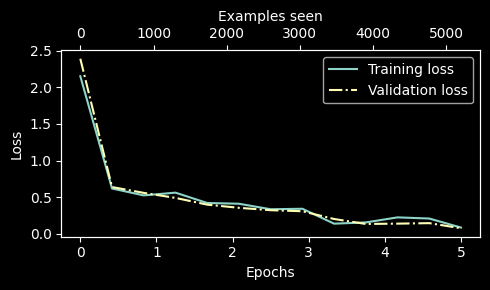

In [52]:
# Listing 6.11 Plotting the classification loss
import matplotlib.pyplot as plt
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")    #A
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()                                                 #B
    ax2.plot(examples_seen, train_values, alpha=0) # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()                                                #C
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


#A 绘制训练轮次与训练和验证损失的变化图
#B 创建一个新的 x 轴，用于显示已处理样本数
#C 调整布局以留出空间

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

图6.16展示了最终的损失曲线。

<img src="../images/chapter6/figure6.16.png" width="75%" />

从图 6.16 中陡峭的下降曲线可以看出，模型在训练数据上的学习效果很好，且没有明显的过拟合迹象，训练集和验证集的损失值几乎没有差距。

> [!NOTE]
>
> **选择训练轮数**
>
> 在训练开始时，我们将 epoch 数量设置为 5。epoch 的具体数量取决于数据集和任务的难度，并没有通用的解决方案或推荐值。5 个 epoch 通常是一个合适的起点。如果在前几个 epoch 后模型出现过拟合迹象（如图 6.16 所示的损失曲线显示验证损失上升），我们可能需要减少 epoch 数量。相反，如果趋势线显示验证损失随着训练仍有下降空间，我们则应增加 epoch 数量。在本例中，5 个 epoch 是合理的选择，因为没有早期过拟合的迹象，且验证损失接近 0。

接下来，继续使用 plot_values 函数绘制分类准确率的图表：

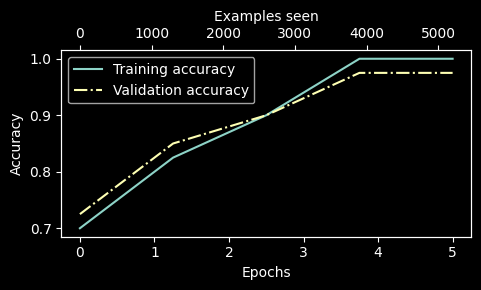

In [53]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

<img src="../images/chapter6/figure6.17.png" width="75%" />

从图 6.17 的准确率曲线可以看出，模型在第 4 到 5 个训练周期后，训练和验证准确率均达到了较高水平。

需要注意的是，我们之前在使用 `train_classifier_simple` 函数时将 `eval_iter` 设置为 5，这意味着我们的训练和验证性能估计仅基于 5 个批次，目的是为了提高训练效率。

现在，我们将通过运行以下代码，计算整个数据集在训练集、验证集和测试集上的性能指标，这次不需要定义 `eval_iter` 值：


In [54]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


由此得到的准确率值如下：
```
Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%
```
可以看到，训练集和测试集的表现几乎相同。

训练集和测试集准确率之间的轻微差异表明训练数据的过拟合程度较低。通常，验证集的准确率会略高于测试集的准确率，这是因为模型开发过程中通常会通过调整超参数来优化验证集上的表现，而这种优化未必能有效地泛化到测试集上。

这种情况很常见，但可以通过调整模型设置来减小这种差距，比如增加 dropout 率（`drop_rate`）或优化器配置中的权重衰减（`weight_decay`）参数。

## 6.8 将 LLM 用于垃圾短信分类

在前几节对模型进行微调和评估后，我们现在进入本章的最后阶段（见图 6.18）：使用模型进行垃圾短信分类。

<img src="../images/chapter6/figure6.18.png" width="75%" />

最后，我们将使用微调后的基于 GPT 的垃圾短信分类模型。以下的 `classify_review` 函数遵循了与本章之前实现的 `SpamDataset` 类似的数据预处理步骤。函数先将文本处理为 token ID，然后使用模型预测一个整数类别标签（与 6.6 节中的实现类似），并返回对应的类别名称：


In [55]:
# Listing 6.12 Using the model to classify new texts
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)                                   #A
    supported_context_length = model.pos_emb.weight.shape[1]

    input_ids = input_ids[:min(max_length, supported_context_length)]    #B

    input_ids += [pad_token_id] * (max_length - len(input_ids))          #C
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)   #D

    with torch.no_grad():                                                #E
        logits = model(input_tensor)[:, -1, :]                           #F
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"                #G


#A 准备模型输入
#B 截断过长序列
#C 填充序列至最长长度
#D 增加批次维度
#E 关闭梯度跟踪，进行模型推理
#F 获取最后一个输出 token 的 logits
#G 返回分类结果

试试用示例文本测试classify_review函数的效果：

In [56]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


训练得到的模型正确预测了‘spam’。接下来，让我们尝试另一个示例：

In [57]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)
print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


这个实例也一样，模型做出了正确预测并返回了‘非垃圾短信’标签。

最后，为了方便后续重复使用模型，避免再次训练，我们可以使用上一章介绍的 `torch.save` 方法来保存模型：

In [58]:
torch.save(model.state_dict(), "review_classifier.pth")

保存后，可以按如下方式加载模型：

In [59]:
model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## 6.9 本章摘要

+ 微调 LLM 有不同的策略，包括分类微调（本章）和指令微调（下一章）。
+ 分类微调是指将 LLM 的输出层替换为一个小型的分类层。
+ 在将文本消息分类为‘垃圾短信’或‘非垃圾短信’的任务中，新的分类层只需要 2 个输出节点；而在之前的章节中，输出节点的数量等于词汇表中的唯一 token 数量，即 50,256。
+ 分类微调任务不是像预训练那样预测下一个词，而是训练模型输出正确的类别标签，例如‘垃圾短信’或‘非垃圾短信’。
+ 在微调阶段，模型的输入是转换为 token ID 的文本，这与预训练阶段类似。
+ 在微调 LLM 之前，我们会加载预训练模型作为基础。
+ 评估分类模型需要计算分类准确率，即正确预测的比例。
+ 微调分类模型时使用的交叉熵损失函数与预训练 LLM 时相同。